# **Tutorial 5: Thermohaline Circulation**

**Week 1, Day 2: Ocean and Atmospheric Reanalysis**

__Content creators:__ Aurora Basinski

**Content reviewers:** Katrina Dobson, Danika Gupta, Maria Gonzalez, Will Gregory, Nahid Hasan, Sherry Mi, Beatriz Cosenza Muralles, Jenna Pearson, Chi Zhang, Ohad Zivan

**Content editors:** Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS and Google deepmind


![CMIP.png](https://github.com/ClimateMatchAcademy/course-content/blob/main/tutorials/Art/CMIP.png?raw=true)|
-


# **Tutorial Objectives**
In the previous tutorial, we discussed how the surface ocean's movement is driven by wind forcing. However, the ocean can also experience movement due to density differences. The large scale ocean movement driven by these density differences is known as the *thermohaline circulation*. The density of ocean water is influenced by temperature (thermo) and salinity (haline), and fluid motion occur in response to pressure gradients caused by these density variations.

In this tutorial, we will use ocean surface data for 2014 to 2016 from the [Estimating the Circulation and Climate of the Ocean (ECCO)](https://www.ecco-group.org/) dataset to 
* Plot sea surface salinity and temperature
* Understand the relationship between salinity, temperature, and ocean density
* Explore the difference between linear and non-linear *equations of state*

# **Setup**

In [1]:
# !pip install seaborn
# !pip install cmocean
# !pip install cartopy
# !pip install geoviews

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cmocean
import pooch
import os
import tempfile
import gsw

In [3]:
# @title Video 1: Speaker Introduction
#Tech team will add code to format and display the video

In [4]:
# helper functions

def pooch_load(filelocation=None,filename=None,processor=None):
    shared_location='/home/jovyan/shared/Data/tutorials/W1D2_StateoftheClimateOceanandAtmosphereReanalysis' # this is different for each day
    user_temp_cache=tempfile.gettempdir()
    
    if os.path.exists(os.path.join(shared_location,filename)):
        file = os.path.join(shared_location,filename)
    else:
        file = pooch.retrieve(filelocation,known_hash=None,fname=os.path.join(user_temp_cache,filename),processor=processor)

    return file

# **Section 1: Plot Surface Temperature and Salinity**
In the slides, we discovered that ocean flows can be driven by density variations in addition to wind-driven circulation. One example of a density-driven flow is the thermohaline circulation. Density in the ocean is influenced by two main factors: 
1. Salinity (higher salinity leads to greater density) and 
2. Temperature (lower temperature generally results in higher density),
3. Also, pressure affects density (higher pressure results in higher density), but it generally has a much smaller impact on ocean density than temperature and salinity. 

To develop a better understanding of how density varies across different regions, let's examine the average salinity and temperature at the ocean surface.

First let's load the data.

In [5]:
# import preprocessed ecco data. This data is surface data that is monthly over the period 2014 to 2016.
filename_theta='surface_theta.nc'
url_theta = "https://osf.io/98ksr/download"

subset_theta= xr.open_dataset(pooch_load(url_theta,filename_theta))
subset_theta

<xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 360)
Coordinates:
    i          (longitude) int64 ...
    k          int64 ...
    j          (latitude) int64 ...
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
    Z          float32 ...
Data variables:
    THETA      (latitude, longitude) float64 ...

In [6]:
filename_salt='surface_salt.nc'
url_salt = "https://osf.io/aufs2/download"

subset_salt= xr.open_dataset(pooch_load(url_salt,filename_salt))
subset_salt

<xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 360)
Coordinates:
    i          (longitude) int64 ...
    k          int64 ...
    j          (latitude) int64 ...
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
    Z          float32 ...
Data variables:
    SALT       (latitude, longitude) float64 ...

In [7]:
# make land points NaN (not a number)
subset_theta=subset_theta.where(subset_theta != 0) # change anywhere that the value is zero to NaN
subset_salt=subset_salt.where(subset_salt != 0) # same
subset_theta=subset_theta.THETA # choose the variable to remove the dimension 
subset_salt=subset_salt.SALT

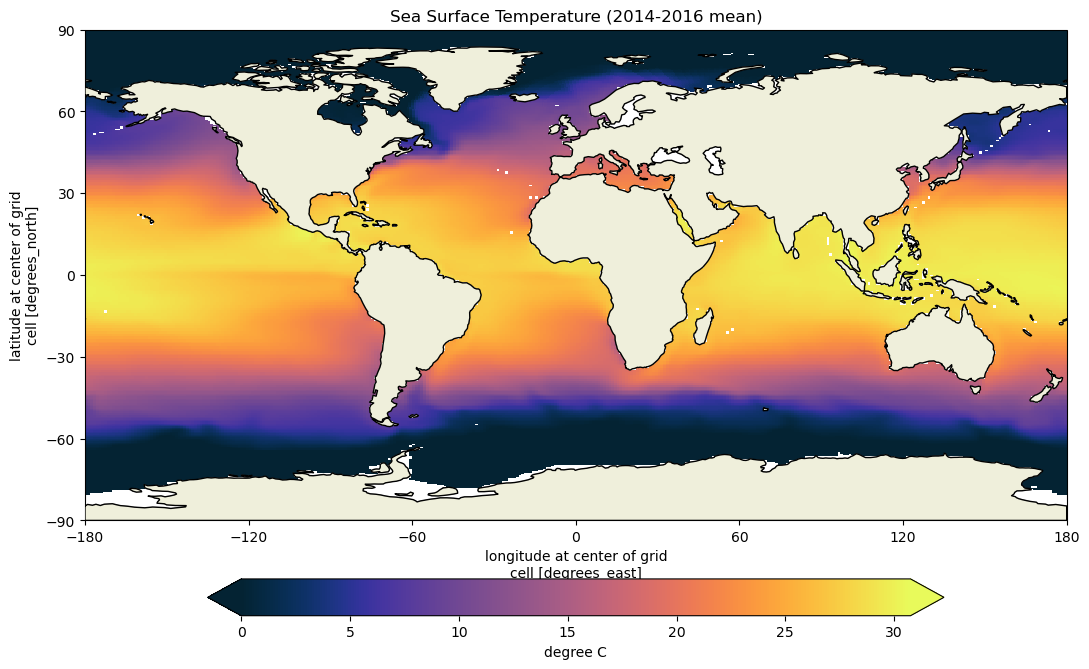

In [16]:
# plot Sea Surface Temprature - similar to plots we used in tutorials 2+3
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()},figsize=(11,12),dpi=100) #this is from cartopy https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html
p=subset_theta.plot(vmin=0,cmap=cmocean.cm.thermal,cbar_kwargs={'shrink':0.75,'orientation':'horizontal','extend':'both','pad':0.05,'label': "degree C"},ax=ax)
ax.coastlines(color='grey',lw=0.5)
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
ax.set_title('Sea Surface Temperature (2014-2016 mean)')
fig.tight_layout()

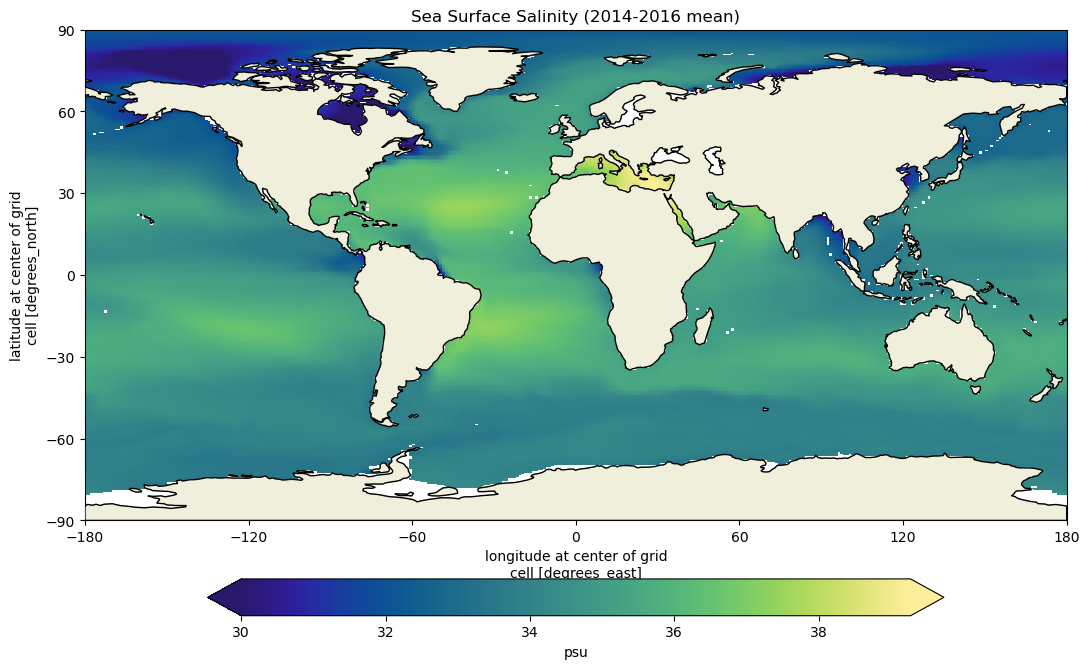

In [15]:
# plot Sea Surface Salinity 
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()},figsize=(11,12),dpi=100) #this is from cartopy https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html
p=subset_salt.plot(cmap=cmocean.cm.haline,vmin=30,cbar_kwargs={'shrink':0.75,'orientation':'horizontal','extend':'both','pad':0.05,'label': "psu"},ax=ax)
ax.coastlines(color='grey',lw=0.5)
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
ax.set_title('Sea Surface Salinity (2014-2016 mean)')
fig.tight_layout()

# **Section 2: Calculating Density from Salinity & Temperature**
The equation relating ocean water density to other water properties is called the ***equation of state***. It is a non-linear function of temperature, salinity, and pressure. This can be expressed as $\rho=\rho(T,S,p)$. Here we will show two ways to calculate the density. 

The first is a *linear approximation* to the equation of state. We will then show how to calculate the full, non-linear equation of state using the `gsw` package

## **Section 2.1: Linearized Equation of State**
Here we take the linearized equation of state from equation 1.57 in Vallis' textbook ["*Atmospheric and Oceanic Fluid Dynamics*"](https://www.cambridge.org/core/books/atmospheric-and-oceanic-fluid-dynamics/41379BDDC4257CBE11143C466F6428A4)

$$ \rho=\rho_0[1-\beta_T(T-T_0)+\beta_S(S-S_0)+\beta_p(p-p_0)] $$

In this equation, $\rho_0\simeq 1027$ is a reference density, $\beta_T \simeq 2*10^{-4}$/K is the thermal expansion coefficient, $\beta_S \simeq 7.6*10^{-4}$/ppt is the haline contraction coefficient, and $\beta_p \simeq 4.4*10^{-10}$/Pa is the compressibility coefficient. The values with $_0$ are reference values, and here we use $T_0=283$K and $S_0=35$. Since surface pressure rarely changes by more than a few percent, let's assume that the pressure at the surface is equal to the reference pressure at every point ($\beta_p(p-p_0)=0$). *The non-linearities in the full equation of state (which we will use later) arise because, in reality, the $\beta$ terms themselves vary with pressure, salinity, and temperature.*

Let's now calculate a global map of surface density using this linear equation of state. Note that since we are using theta and salt *datasets*, our result will also be a dataset.

In [10]:
rho_linear=1027*(1-2E-4*(subset_theta+273.15-283)+7.6E-4*(subset_salt-35)) 
rho_linear

<xarray.DataArray (latitude: 360, longitude: 720)>
array([[          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       ...,
       [1027.0871889 , 1027.0871889 , 1027.0871889 , ..., 1027.0871889 ,
        1027.0871889 , 1027.0871889 ],
       [1027.11507147, 1027.11507147, 1027.11507147, ..., 1027.11507147,
        1027.11507147, 1027.11507147],
       [1027.17755495, 1027.17755495, 1027.17755495, ..., 1027.17755495,
        1027.17755495, 1027.17755495]])
Coordinates:
    i          (longitude) int64 0 1 2 3 4 5 6 7 ... 713 714 715 716 717 718 719
    k          int64 0
    j          (latitude) int64 0 1 2 3 4 5 6 7 ... 353 354 355 356 357 358 359
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
    Z          float32 -5.0

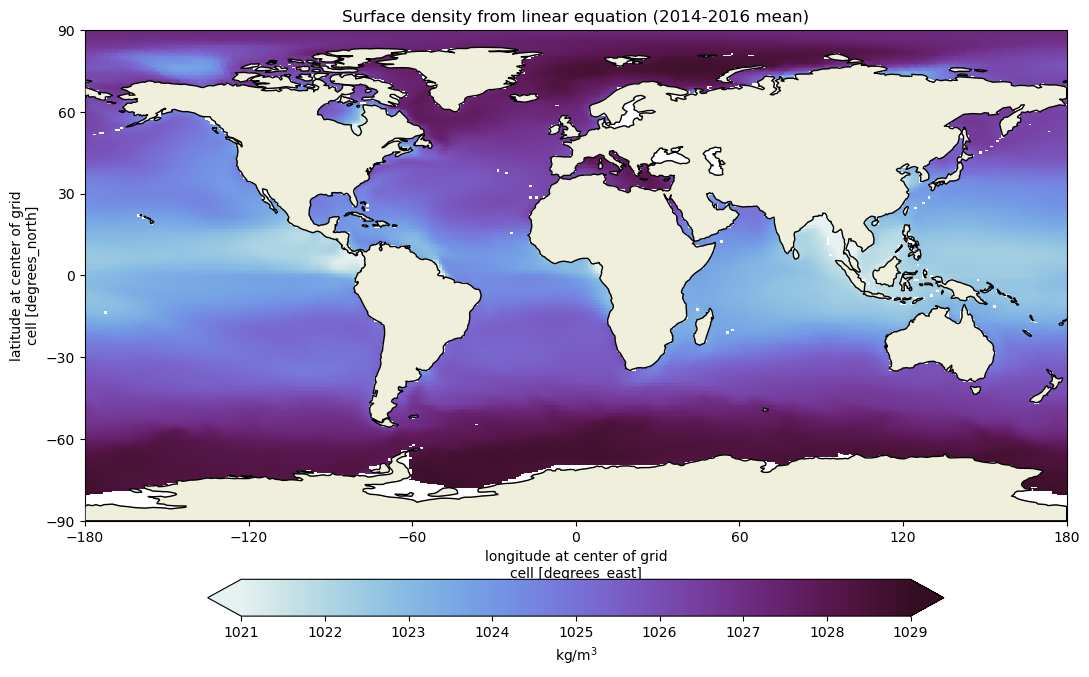

In [14]:
# plot linearized density
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()},figsize=(11,12),dpi=100) #this is from cartopy https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html
p=rho_linear.plot(cmap=cmocean.cm.dense,vmin=1021, vmax=1029, cbar_kwargs={'shrink':0.75,'orientation':'horizontal','extend':'both','pad':0.05,'label': "kg/m$^3$"},ax=ax)
ax.coastlines(color='grey',lw=0.5)
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
ax.set_title('Surface density from linear equation (2014-2016 mean)')
fig.tight_layout()

## **Section 2.2: Full Nonlinear Equation of State**
The full, non-linear equation of state is more complicated than the linear equation we just used. It contains dozens of equations which are impractical to code in this tutorial. Fortunately packages exist to do this calculation!

Here we will compute surface density from the full nonlinear equation in `python` using the `gsw` package which is a Python implementation of the [Thermodynamic Equation of Seawater 2010 (TEOS-10)](https://teos-10.github.io/GSW-Python/)

In [17]:
CT = gsw.CT_from_pt(subset_salt,subset_theta) #get conservative temperature from potential temperature
rho_nonlinear=gsw.rho(subset_salt,CT,0)

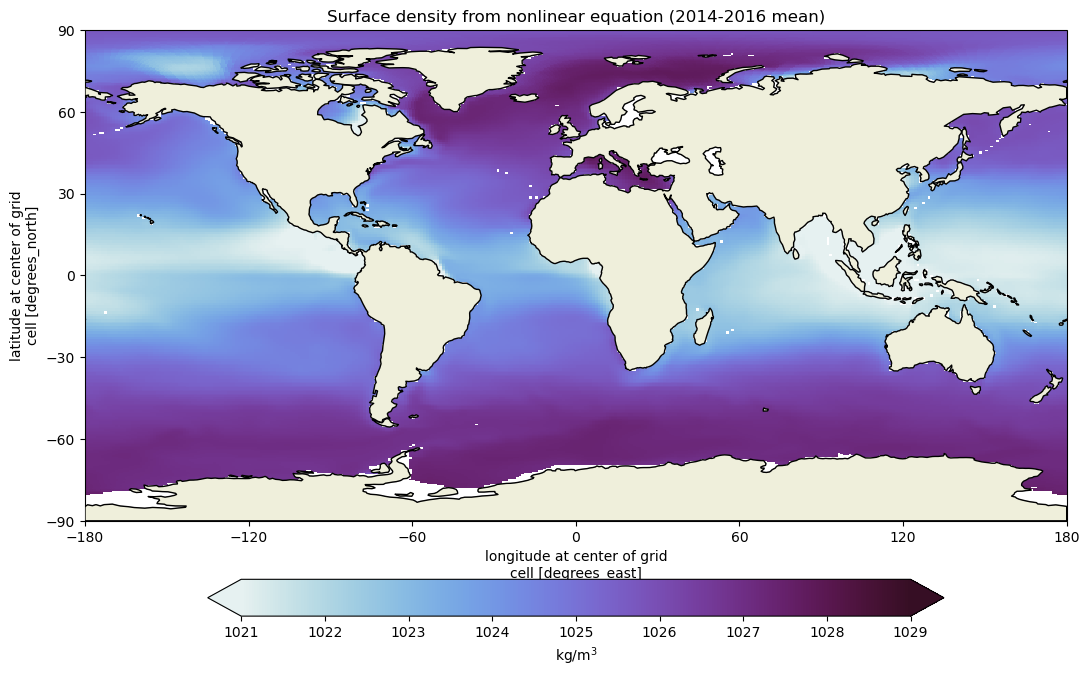

In [18]:
# plot density from full nonlinear equation
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()},figsize=(11,12),dpi=100) #this is from cartopy https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html
p=rho_nonlinear.plot(cmap=cmocean.cm.dense,vmin=1021, vmax=1029, cbar_kwargs={'shrink':0.75,'orientation':'horizontal','extend':'both','pad':0.05,'label': "kg/m$^3$"},ax=ax)
ax.coastlines(color='grey',lw=0.5)
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
ax.set_title('Surface density from nonlinear equation (2014-2016 mean)')
fig.tight_layout()

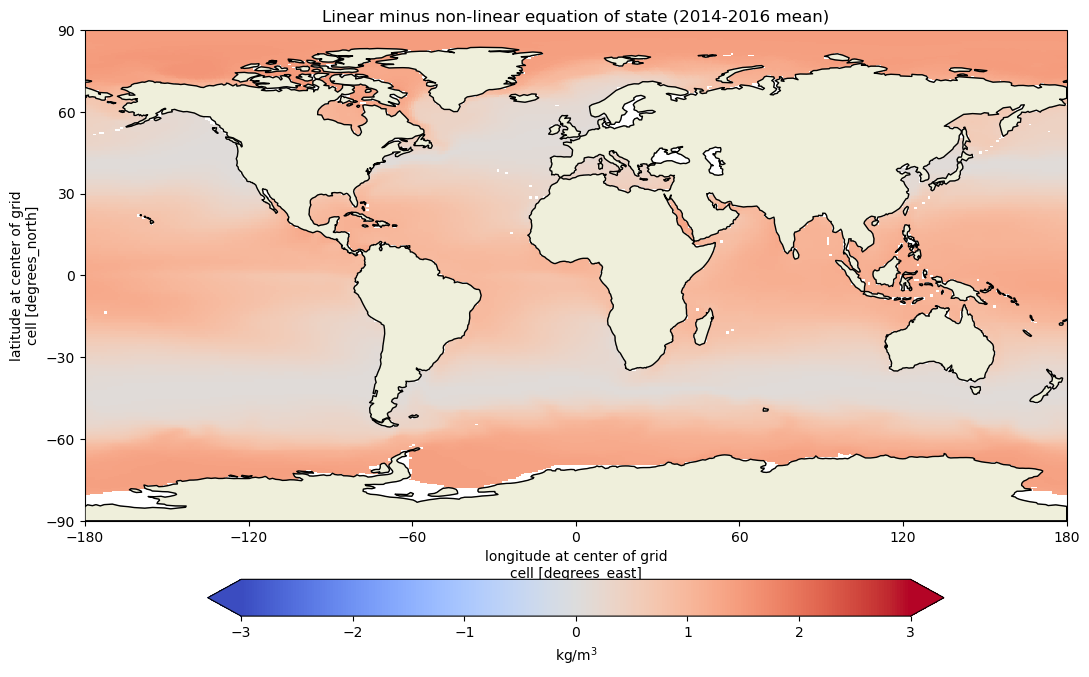

In [20]:
# plot difference between linear and non-linear equations of state
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()},figsize=(11,12),dpi=100) #this is from cartopy https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html
p=(rho_linear - rho_nonlinear).plot(cmap='coolwarm',vmin=-3, vmax=3, cbar_kwargs={'shrink':0.75,'orientation':'horizontal','extend':'both','pad':0.05,'label': "kg/m$^3$"},ax=ax)
ax.coastlines(color='grey',lw=0.5)
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
ax.set_title('Linear minus non-linear equation of state (2014-2016 mean)')
fig.tight_layout()

Upon comparing the two equations of state, we observe that they are generally similar, but certain differences arise. These differences stem from the nonlinearity of the equation of state, where the haline contraction coefficient and thermal expansion coefficient are not constant as assumed in our linear equation of state.

Irrespective of the method used to calculate density, we notice the presence of horizontal density variations (gradients) at the ocean surface. For instance, seawater tends to be less dense in the subtropics and denser near the poles. These density differences play a crucial role in driving ocean currents, as we discussed in the slides.

These findings emphasize the significant density gradients in the ocean, which shape oceanic circulation patterns. The nonlinearity in the equation of state contributes to these density variations, which in turn also influences the movement of water masses and the formation of currents.

### **Questions 2.2**

1. Considering the nonlinear equation of state and TEOS-10, how do changes in ocean salinity and temperature uniquely impact the haline contraction and thermal expansion coefficients, thereby affecting density and ocean currents?
2. One place that deep convection, a critical component of thermohaline circulation occurs, is in the North Atlantic Ocean to the south of Greenland. Based on the density maps you made, does it make sense that this would be an ideal location for a deepwater mass to form?

In [ ]:
# to_remove explanation

""" 
1. When salinity rises, the water's capacity to contract in response to added salt (haline contraction coefficient) generally increases. Similarly, as temperature decreases, water's volume expansion due to heating (thermal expansion coefficient) generally decreases. These variations can significantly affect seawater density, creating pressure gradients that in turn influence the intensity and direction of ocean currents.
2. The surface water in this region has a larger density than the surface water surrounding it, making it relatively likely that this surface water will be dense enough to sink and mix with the waters below. Conversely, the same latitude in the Pacific is much less dense (due to fresher water) and there is no deep water formation that takes place here.
""";


# **Summary**

In this tutorial, you explored sea surface salinity and temperature data from 2014 to 2016, and how those contribute to surface density patterns through the equation of state. You also compared the linear and non-linear equation of state and analyzed their differences.

# **Resources**

Data for this tutorial can be accessed [here](https://www.ecco-group.org/).